# Linear Regression Details

We shall look at some standard regression terminology and also how some of the numbers shown in the regression output are actually computed. 

Let us use the GDP dataset from FRED (https://fred.stlouisfed.org/series/GDP) which gives quarterly data on the Gross Domestic Product (units are billions of dollars).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
gdp = pd.read_csv('GDP-Jan2025FRED.csv')
print(gdp.head(10))

  observation_date      GDP
0       1947-01-01  243.164
1       1947-04-01  245.968
2       1947-07-01  249.585
3       1947-10-01  259.745
4       1948-01-01  265.742
5       1948-04-01  272.567
6       1948-07-01  279.196
7       1948-10-01  280.366
8       1949-01-01  275.034
9       1949-04-01  271.351


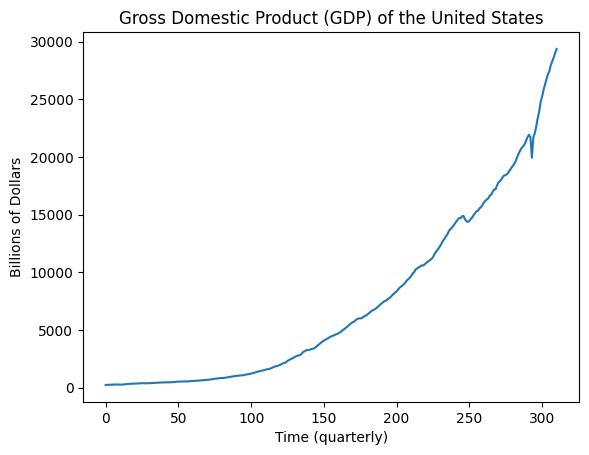

In [3]:
plt.plot(gdp['GDP'])
plt.xlabel("Time (quarterly)")
plt.ylabel("Billions of Dollars")
plt.title("Gross Domestic Product (GDP) of the United States")
plt.show()

Let us fit a cubic trend model to this dataset given by: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 t^3 + \epsilon_t
\end{equation*}
for $t = 1, \dots, n$ where $n$ is the total number of observations in the dataset. In vector-matrix notation, this model can be equivalently be represented as: 
\begin{equation*}
   y = X \beta + \epsilon
\end{equation*}
where
\begin{equation*}
   y = \begin{pmatrix} y_1\\ y_2 \\ \cdot \\ \cdot \\ \cdot \\ y_n \end{pmatrix} ~~~
   X = \begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & 2 & 2^2 & 2^3 \\ 1 & 3 & 3^2 & 3^3 \\ \cdot & \cdot & \cdot & \cdot \\ \cdot & \cdot & \cdot & \cdot \\ \cdot & \cdot & \cdot & \cdot \\ 1 & n & n^2 & n^3 \end{pmatrix} ~~~ \beta = \begin{pmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3 \end{pmatrix} ~ ~ ~ \epsilon = \begin{pmatrix} \epsilon_1 \\ \epsilon_2 \\ \cdot \\ \cdot \\ \cdot \\ \epsilon_n \end{pmatrix}
\end{equation*}
Observe $y$ is $n \times 1$, $X$ is $n \times 4$, $\beta$ is $4 \times 1$ and $\epsilon$ is $n \times 1$. The entries $\epsilon_1, \dots, \epsilon_n$ of the vector $\epsilon$ are known as errors and we assume that $\epsilon_i \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$. There are 5 parameters in this model $\beta_0, \beta_1, \beta_2, \beta_3, \sigma$ which we need to estimate from the data. 

To implement regression, we simply need to create $y$ and $X$ and give them as input to the sm.OLS function. 

The following code creates $y$ and $X$. 

In [4]:
y = gdp['GDP']
n = len(y)
x = np.arange(1, n + 1)
x2 = x ** 2
x3 = x ** 3
X = np.column_stack([np.ones(n),x, x2, x3])

print(X[:5])

[[  1.   1.   1.   1.]
 [  1.   2.   4.   8.]
 [  1.   3.   9.  27.]
 [  1.   4.  16.  64.]
 [  1.   5.  25. 125.]]


Now we simply use sm.OLS with $y$ and $X$: 

In [5]:
md = sm.OLS(y, X).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.000e+04
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:30:14   Log-Likelihood:                -2402.2
No. Observations:                 311   AIC:                             4812.
Df Residuals:                     307   BIC:                             4827.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        292.1841    126.498      2.310      0.0

### Least Squares Estimates

The information on the estimates $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3$ along with associated uncertainties (standard errors) are given in the table near the middle of the output. Specifically, the estimates from the above table are $\hat{\beta}_0 = 292.181$, $\hat{\beta}_1 = -2.5806$, $\hat{\beta}_2 = 0.0759$ and $\hat{\beta}_3 = 0.0007$. These numbers can also be obtained using model.params as follows:

In [6]:
print(md.params)

const    292.184077
x1        -2.580592
x2         0.075924
x3         0.000665
dtype: float64



These estimates are known as the Least Squares Estimates (also the same as Maximum Likelihood Estimates) and they are computed via the formula: 
\begin{equation*}
   \hat{\beta} = \begin{pmatrix} \hat{\beta}_0 \\ \hat{\beta}_1 \\ \hat{\beta}_2 \\ \hat{\beta}_3 \end{pmatrix} = (X^T X)^{-1} X^T y. 
\end{equation*}
Let us verify that this formula indeed gives the reported estimates. 

In [7]:
XTX = np.dot(X.T, X)
XTX_inverse = np.linalg.inv(XTX)
XTX_inverse_XT = np.dot(XTX_inverse, X.T)
betahat = np.dot(XTX_inverse_XT, y)

print(np.column_stack([betahat, md.params]))

[[ 2.92184077e+02  2.92184077e+02]
 [-2.58059163e+00 -2.58059163e+00]
 [ 7.59236235e-02  7.59236235e-02]
 [ 6.64683542e-04  6.64683542e-04]]


In reality, sm.OLS does not use the above formula directly (even though the formula is the correct one), instead it uses some efficient linear algebra methods to solve the linear equations $X^T X \beta = X^T y$.

### Fitted Values

The next quantity to understand are the fitted values. These are given by model.fittedvalues and they are obtained via the simple formula: 
\begin{equation*}
   \hat{y} = X \hat{\beta}
\end{equation*}
The entries $\hat{y}_1, \dots, \hat{y}_n$ of the vector $\hat{y}$ are known as the fitted values. Let us check the correctness of this formula. 

In [8]:
fvals = np.dot(X, betahat)

print(np.column_stack([fvals[:10], md.fittedvalues[:10]]))

[[289.68007406 289.68007406]
 [287.33190609 287.33190609]
 [285.14356157 285.14356157]
 [283.1190286  283.1190286 ]
 [281.26229528 281.26229529]
 [279.57734972 279.57734972]
 [278.06818001 278.06818001]
 [276.73877426 276.73877426]
 [275.59312056 275.59312056]
 [274.63520702 274.63520702]]


To assess how well the regression model fits the data, we plot the fitted values along with the original data. 

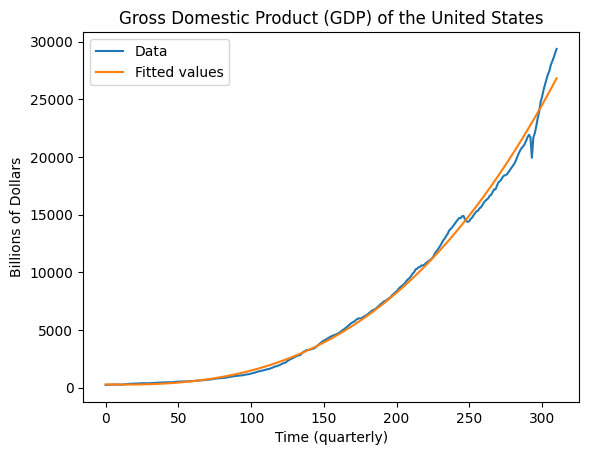

In [9]:
plt.plot(y, label = "Data")
plt.plot(md.fittedvalues, label = "Fitted values")
plt.legend()
plt.xlabel("Time (quarterly)")
plt.ylabel("Billions of Dollars")
plt.title("Gross Domestic Product (GDP) of the United States")
plt.show()

### Residuals

The residuals simply are the differences between the observed data and the fitted values. We use the notation $e$ for the vector of residuals:
\begin{equation*}
  e = y - \hat{y}
\end{equation*}
The $i^{th}$ residual is simply the $i^{th}$ entry of $e$. 

In [10]:
residuals = y - fvals
print(np.column_stack([md.resid[:10], residuals[:10]]))

[[-46.51607406 -46.51607406]
 [-41.36390609 -41.36390609]
 [-35.55856157 -35.55856157]
 [-23.3740286  -23.3740286 ]
 [-15.52029529 -15.52029528]
 [ -7.01034972  -7.01034972]
 [  1.12781999   1.12781999]
 [  3.62722574   3.62722574]
 [ -0.55912056  -0.55912056]
 [ -3.28420702  -3.28420702]]


A plot of the residuals against time is an important diagnostic tool which can tell us about the effectiveness of the fitted model. 

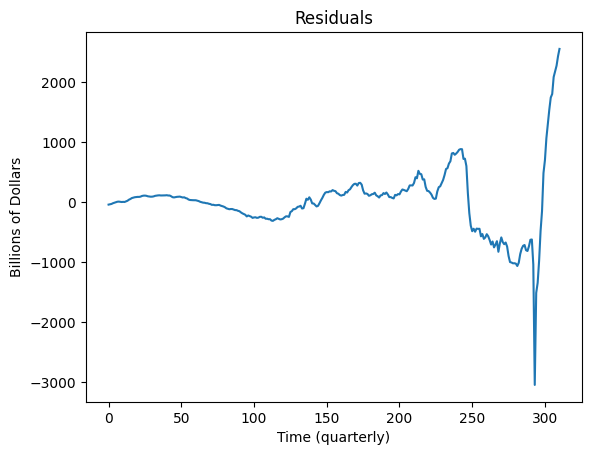

In [19]:
plt.plot(md.resid)
plt.xlabel("Time (quarterly)")
plt.ylabel("Billions of Dollars")
plt.title("Residuals")
plt.show()

From this plot, we see that there are some very large residuals indicating the presence of time points where the model predictions are quite far off from the observed values. This could be because of outliers or some systematic features that the model is missing. Also the residual plot looks quite smooth which indicates that there is some correlation between nearby residuals. This can be better visualized via the **acf plot** (sometimes known as the correlogram) of the residuals.

[ 2.99767066e+02 -2.99623705e+00  9.99834849e-02  1.00002346e-03]


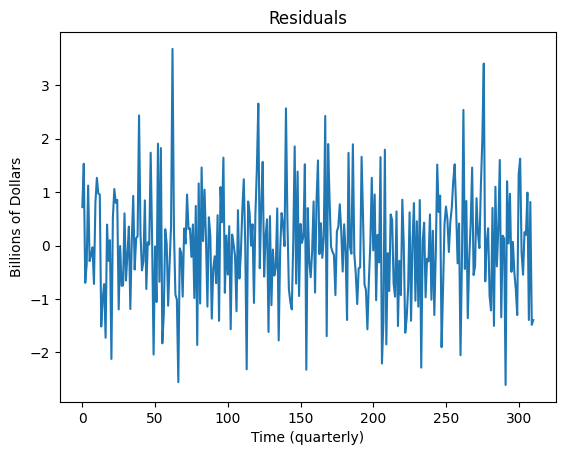

In [34]:
# For comparison
gamma = np.array([300.0, -3.0, 0.1, 0.001])
z = np.dot(X, gamma) + np.random.normal(0, 1, X.shape[0])

sim_model = sm.OLS(z, X).fit()
print(sim_model.params)

plt.plot(sim_model.resid)
plt.xlabel("Time (quarterly)")
plt.ylabel("Billions of Dollars")
plt.title("Residuals")
plt.show()

### ACF Plot

Given a time series dataset $z_1, \dots, z_n$ and a **lag** h, define
\begin{equation}
   r_h := \frac{\sum_{t=1}^{n-h} (z_t - \bar{z})(z_{t+h} - \bar{z})}{\sum_{t=1}^n (z_t - \bar{z})^2}
\end{equation}
for $h = 0, 1, 2, \dots$. Here $\bar{z}$ is simply the mean of $z_1, \dots, z_n$. The acf plot graphs $h$ on the x-axis and $r_h$ on the y-axis. The quantity $r_h$ is known as the **sample autocorrelation** of the data at lag $h$ (acf stands for "Autocorrelation Function"). When $n$ is large and $h$ is small, $r_h$ approximates the sample correlation in the bivariate dataset $(z_1, z_{h+1}), (z_2, z_{h+2}), \dots, (z_{n-h}, z_n)$. The actual formula for the sample correlation in the bivariate dataset $(z_1, z_{h+1}), (z_2, z_{h+2}), \dots, (z_{n-h}, z_n)$ is:
\begin{equation}
   \frac{\sum_{t=1}^{n-h} (z_t - \bar{z}^{(1)})(z_{t+h} - \bar{z}^{(2)})}{\sqrt{\sum_{t=1}^{n-h} (z_t - \bar{z}^{(1)})^2}\sqrt{\sum_{t=1}^{n-h} (z_{t+h} - \bar{z}^{(2)})^2}} ~~~ \text{ where } \bar{z}^{(1)} = \frac{\sum_{t=1}^{n-h} z_t}{n-h} ~~ \text{ and } ~~ \bar{z}^{(2)} = \frac{\sum_{t=1}^{n-h} z_{t+h}}{n-h}.
\end{equation}
If we now use the simple approximations $\bar{z}^{(1)} \approx \bar{z}$ and $\bar{z}^{(2)} \approx \bar{z}$ and replace the sums in the denominator to range over all $t = 1, \dots, n$ (as opposed to $t = 1, \dots, n-h$), we get the formulat for $r_h$. These approximations are reasonable when $n$ is large and $h$ is small. 

The ACF plot tells us about the size of the correlations between the successive values of given time series. Note that $r_0$ is always equal to 1. So we are really looking at the size of $r_h$ for $h \geq 1$. 

Here is the ACF plot for the residuals of the regression fitted to the GDP data. 


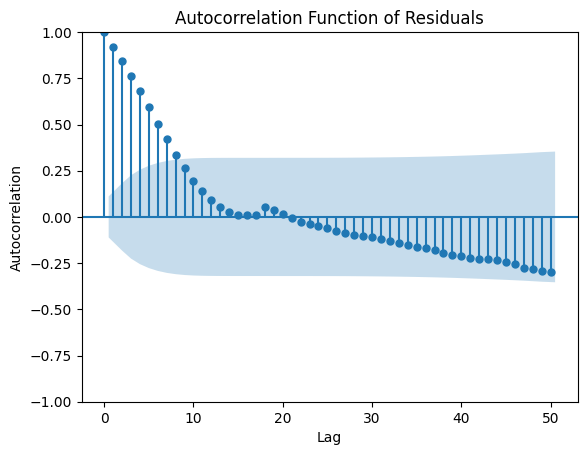

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(md.resid, lags = 50)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function of Residuals")
plt.show()

This plot reveals that the residuals have significant autocorrelations. Note the presence of the blue shaded region that is automatically supplied by the plot. This is supposed to help us assess the size of the autocorrelations. The idea is that even if the data is i.i.d $N(0, \sigma^2)$ so that there  is are no autocorrelations, by randomness, some of the computed sample autocorrelations will be nonzero. The typical size of these **null** autocorrelations is indicated by the blue shaded region. The implication is that we should only consider the size of an autocorrelation as significantly different from zero if it sticks out of the blue regions. 

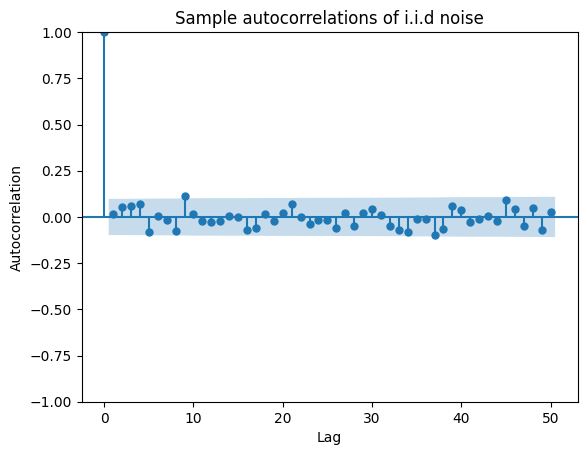

In [21]:
iidz = np.random.normal(size = 400)
plot_acf(iidz, lags = 50)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Sample autocorrelations of i.i.d noise")
plt.show()
#note that the acf value at h = 0 is always 1

Let us get back to the ACF plot of the residuals from the model fit to the GDP data. There are significant autocorrelations at small lags (especially $h = 1, 2, 3$). The implication of this is the following. Suppose we want to predict the GDP for the future quarter immediately following the last data observation. We can use the predicted value given by the model. But the last residual value is about 2548 which is quite larger than zero. Because of significant positive autocorrelation at lag 1, we would expect the next residual value to be quite positive as well. This means that we should adjust the predicted value given by the model upwards by about 2548 for a better forecast. This makes sense from the plot of the data and fitted values as well. We shall study such procedures later in the course.

In [22]:
#the value of the last residual
md.resid[n-1]

2548.0506349268508

### Residual Sum of Squares (RSS) and Residual df 

Two other commonly used terms (in connection with residuals) are the Residual Sum of Squares (RSS) and the Residual Degrees of Freedom. The RSS is simply the sum of the squares of the residuals: 
\begin{equation*}
   \text{RSS} = \sum_{i=1}^n e_i^2 = \sum_{t=1}^n \left(y_t - \hat{\beta}_0 - \hat{\beta}_1 t - \hat{\beta}_2 t^2 - \hat{\beta}_3 t^3 \right)^2
\end{equation*}
RSS is simply equal to the smallest possible of the sum of squares criterion $S(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3)$ (recall from lecture that $S(\beta_0, \beta_1, \beta_2, \beta_3) = \sum_{t=1}^n (y_t - \beta_0 - \beta_1 t - \beta_2 t^2 - \beta_3 t^3)^2$).

The vector of residuals has the following important property: $X^T e = 0$. This can be proved as follows: 
\begin{equation*}
   X^T e = X^T (y - \hat{y}) = X^T (y - X \hat{\beta}) = X^T (y - X (X^T X)^{-1} X^T y) = X^T y - X^T X (X^T X)^{-1} X^T y = X^T y - X^T y = 0. 
\end{equation*}
$X^T e = 0$ means that the dot product between every column of $X$ and $e$ equals 0. In our regression model for GDP, $X^T e = 0$ is equivalent to: 
\begin{equation*}
   \sum_{t = 1}^n e_t = 0 ~~~~  \sum_{t = 1}^n t e_t = 0 ~~~~  \sum_{t = 1}^n t^2 e_t = 0 ~~~~  \sum_{t = 1}^n t^3 e_t = 0
\end{equation*}
Even though there are $n$ residuals $e_1, \dots, e_n$, they have to satisfy the above four equality constraints. Therefore, the effective number of 'free' residuals is $n-4$. Thus the residual degrees of freedom equals $n-4$. 

More generally, the residual df equals the number of observations ($n$) minus the number of columns in the $X$ matrix. 

### Estimate of $\sigma$: the residual standard error

The estimate of $\sigma$ is given by: 
\begin{equation*}
   \hat{\sigma} = \sqrt{\frac{RSS}{n-4}} = \sqrt{\frac{S(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3)}{n-4}}
\end{equation*}
This quantity is sometimes called the Residual Standard Error. The value of the Residual Standard Error can be used to assess the size of the residuals (residuals much larger than say twice the Residual Standard Error indicate points where the model fits particularly poorly).

In [23]:
rss = np.sum(md.resid ** 2)
rse = np.sqrt(rss/(n - 4))

print(rse)

550.9932711741245


This intuitively means that residuals with magnitude above 1100 are points where the model fits particularly poorly. From a look at the plot of the residuals against time, there are many residuals which are this large in magnitude. 

### Standard Errors of the coefficient estimates

The standard errors corresponding to $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3$ are the square roots of the diagonal entries of $\hat{\sigma}^2 (X^T X)^{-1}$. They are given by md.bse as verified below. 

In [24]:
sebetahat_squared = (rse ** 2)*(np.diag(XTX_inverse))
sebetahat = np.sqrt(sebetahat_squared)

print(np.array([md.bse, sebetahat]))

[[1.26498064e+02 3.50560340e+00 2.60867093e-02 5.49661580e-05]
 [1.26498064e+02 3.50560340e+00 2.60867093e-02 5.49661580e-05]]


### t-statistic and confidence intervals for the coefficients

The $t$-statistic for each coefficient is simply the estimate divided by the standard error. The confidence interval for $\beta_j$ is given by:
\begin{equation*}
   \left[\hat{\beta}_j - t_{\alpha/2, n-4} \text{ standard error of } \hat{\beta}_j, \hat{\beta}_j + t_{\alpha/2, n-4} \text{ standard error of } \hat{\beta}_j  \right]
\end{equation*}
where $t_{\alpha/2, n-4}$ is the point beyond the $t$-distribution with $n-4$ degrees of freedom gives probability mass $\alpha/2$. The above formula is the result of: 
\begin{equation*}
   \frac{\beta_j - \hat{\beta}_j}{\text{ standard error of } \hat{\beta}_j} \mid \text{ data } \sim t-\text{distribution with} ~n-4 \text{ d.f}
\end{equation*}
The above statement can also be interpreted in a frequentist sense (then the conditional on data will be removed and the randomness will be over the data with fixed $\beta_j$).

In [25]:
from scipy.stats import t

alpha = 0.05
qt = t.ppf(1 - (alpha/2), n-4) #area to the right equaling alpha/2 is the same as area to the left equaling 1-alpha/2
print(qt)

cilower = md.params - md.bse*qt
ciupper = md.params + md.bse*qt
print(np.column_stack([cilower, ciupper]))
print(md.summary())


1.9677212881552213
[[ 4.32711446e+01  5.41097010e+02]
 [-9.47864205e+00  4.31745880e+00]
 [ 2.45922503e-02  1.27254997e-01]
 [ 5.56525463e-04  7.72841622e-04]]
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.000e+04
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:37:42   Log-Likelihood:                -2402.2
No. Observations:                 311   AIC:                             4812.
Df Residuals:                     307   BIC:                             4827.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

### Visualizing Uncertainty

It was showed in Lecture 4 that the posterior distribution of $\beta$ (this is the vector of coefficients) is given by
\begin{equation*}
   \beta \mid \text{data} \sim t_{4} \left(\hat{\beta}, \hat{\sigma}^2 (X^T X)^{-1}, n - 4 \right)
\end{equation*}
From the definition of the $t$-distribution above, we also know that the distribution above coincides with the distribution of
\begin{equation*}
    \hat{\beta} + \frac{Z}{\sqrt{V/(n-4)}}
\end{equation*}
where $Z \sim N(0, \hat{\sigma}^2 (X^T X)^{-1})$ and $V \sim \chi^2_{n-4}$ are independent. Using this, we can generate vectors $\beta$ from their posterior distribution and then plot the regression curves corresponding to the different generated $\beta$ vectors. This will give us an idea of the uncertainty underlying the coefficients. 


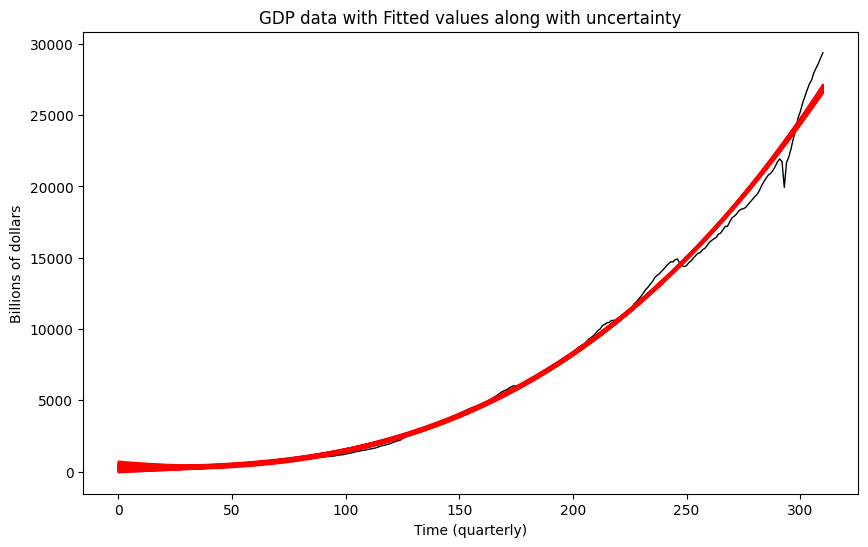

In [26]:
N = 200 #this the number of posterior samples that we shall draw
Sigma_mat = (rse ** 2)*(XTX_inverse)
#print(Sigma_mat)

from scipy.stats import chi2, multivariate_normal

chi_samples = chi2(df = n-4).rvs(N)
norm_samples = multivariate_normal(cov = Sigma_mat, allow_singular = True).rvs(N)
post_samples = np.tile(betahat, (N, 1)) + norm_samples / np.sqrt(chi_samples / (n-4))[:, None]
#print(post_samples)

plt.figure(figsize = (10, 6))
plt.plot(y, linewidth = 1, color = 'black')
for k in range(N):
    fvalsnew = np.dot(X, post_samples[k])
    plt.plot(fvalsnew, color = 'red', linewidth = 1)
plt.xlabel('Time (quarterly)')
plt.ylabel('Billions of dollars')
plt.title('GDP data with Fitted values along with uncertainty')
plt.show()

Even though $N = 200$ regression curves have been plotted, they are still fairly clustered together. This suggests that the uncertainty in these estimates is fairly small. 

### Other comments

When analyzing such a dataset, it is also common to work with logs instead of the raw GDP numbers directly i.e., take $y = \log (GDP)$. Another common approach is to work with difference of logs (this is interpreted as the GDP growth rate): $y_t = \log(GDP_t) - \log(GDP_{t-1})$. For prediction purposes, note that if you predict a future value of the difference of the logs, then this predicted value can be used to also obtain a prediction for the original data. 